<Axes: xlabel='Date'>

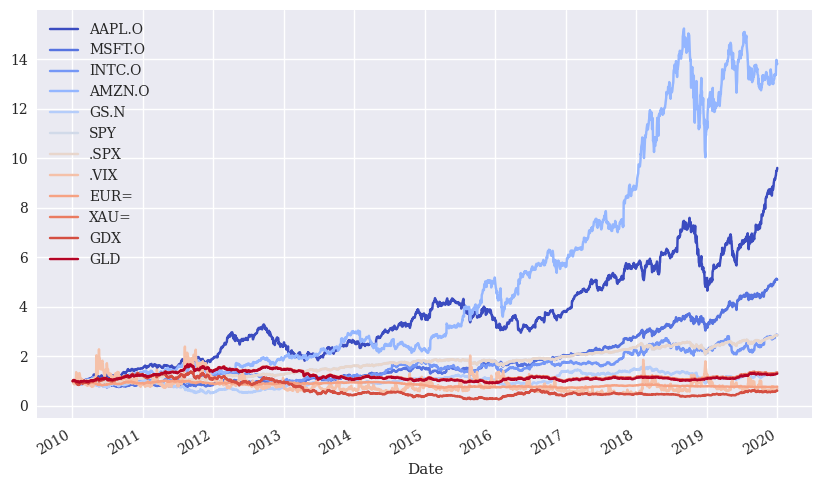

In [14]:
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn-v0_8')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
pd.set_option('display.precision', 4)
np.set_printoptions(suppress=True, precision=4)

# 데이터를 데이터프레임 객체로 읽는다.
url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'
data = pd.read_csv(url, index_col=0, parse_dates=True).dropna()

# 정규화된 시계열 데이터를 그린다.
(data / data.iloc[0]).plot(figsize=(10,6), cmap='coolwarm')

In [15]:
''' 이제 모든 금융 시계열에 대한 가격 데이터를 시간 지연시켜 데이터프레임 객체에 저장한다 '''

# 시간 지연 수(거래 당일)
lags = 7

def add_lags(data, ric, lags):
    cols = []
    df = pd.DataFrame(data[ric])
    for lag in range(1, lags+1):
        # 컬럼 이름 생성
        col = 'lag={}'.format(lag)
        # 가격 데이터 지연
        df[col] = df[ric].shift(lag)
        # 리스트 객체에 컬럼 이름 추가
        cols.append(col)
    # 모든 불완전한 데이터 행 제거
    df.dropna(inplace=True)
    return df, cols

dfs = {}
for sym in data.columns:
    # 시간 지연된 데이터 생성
    df, cols = add_lags(data, sym, lags)
    # 사전 객체에 결과 저장
    dfs[sym] = df

# 시간 지연된 가격 데이터 샘플 표시
dfs[sym].head(7)

,GLD,lag=1,lag=2,lag=3,lag=4,lag=5,lag=6,lag=7
Date,,,,,,,,
2010-01-13,111.54,110.49,112.85,111.37,110.82,111.51,109.70,109.80
2010-01-14,112.03,111.54,110.49,112.85,111.37,110.82,111.51,109.70
2010-01-15,110.86,112.03,111.54,110.49,112.85,111.37,110.82,111.51
2010-01-19,111.52,110.86,112.03,111.54,110.49,112.85,111.37,110.82
2010-01-20,108.94,111.52,110.86,112.03,111.54,110.49,112.85,111.37
2010-01-21,107.37,108.94,111.52,110.86,112.03,111.54,110.49,112.85
2010-01-22,107.17,107.37,108.94,111.52,110.86,112.03,111.54,110.49


,lag=1,lag=2,lag=3,lag=4,lag=5,lag=6,lag=7
AAPL.O,1.0106,-0.0592,0.0258,0.0535,-0.0172,0.0060,-0.0184
MSFT.O,0.8928,0.0112,0.1175,-0.0832,-0.0258,0.0567,0.0323
INTC.O,0.9519,0.0579,0.0490,-0.0772,-0.0373,0.0449,0.0112
AMZN.O,0.9799,-0.0134,0.0206,0.0007,0.0525,-0.0452,0.0056
GS.N,0.9806,0.0342,-0.0172,0.0042,-0.0387,0.0585,-0.0215
SPY,0.9692,0.0067,0.0228,-0.0244,-0.0237,0.0379,0.0121
.SPX,0.9672,0.0106,0.0219,-0.0252,-0.0318,0.0515,0.0063
.VIX,0.8823,0.0591,-0.0289,0.0284,-0.0256,0.0511,0.0306
EUR=,0.9859,0.0239,-0.0484,0.0508,-0.0217,0.0149,-0.0055
XAU=,0.9864,0.0069,0.0166,-0.0215,0.0044,0.0198,-0.0125


<Axes: >

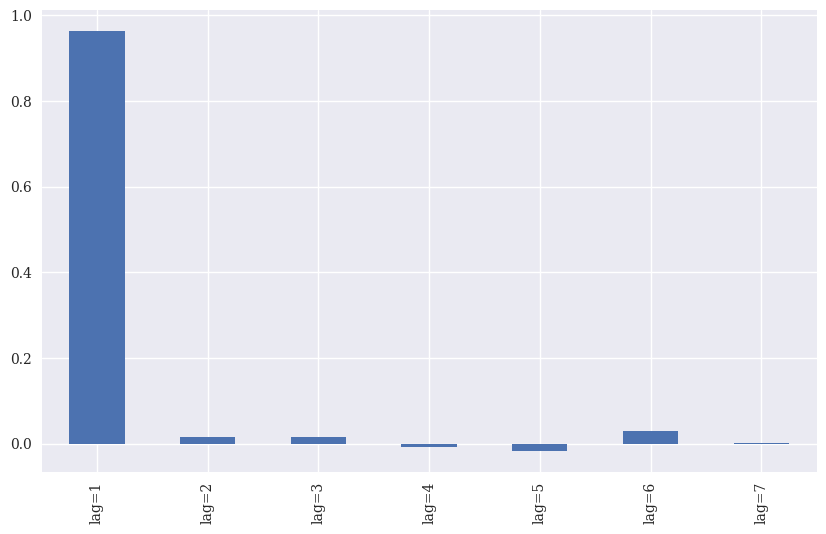

In [16]:
''' 데이터가 준비되었으므로 회귀분석을 수행한다. '''

regs = {}
for sym in data.columns:
    # 현재 시계열 데이터
    df = dfs[sym]
    # 회귀분석 수행
    reg = np.linalg.lstsq(df[cols], df[sym], rcond=-1)[0]
    # 사전 객체에 최적 회귀분석 파라미터 저장
    regs[sym] = reg

# 단일 ndarray 객체에 최적 결과 융합
rega = np.stack(tuple(regs.values()))

# 결과를 데이터프레임에 저장
regd = pd.DataFrame(rega, columns=cols, index=data.columns)
display(regd)

# 모든 지연에 대한 평균 회귀분석 파라미터(가중치)를 시각화
regd.mean().plot(kind='bar', figsize=(10,6))

In [17]:
# 지연된 시계열의 상수계수 표시 - 강한 상관관계를 나타낸다.
display(dfs[sym].corr())

# augmented dickey-fuller를 사용한 정상성 검정
from statsmodels.tsa.stattools import adfuller
display(adfuller(data[sym].dropna()))

,GLD,lag=1,lag=2,lag=3,lag=4,lag=5,lag=6,lag=7
GLD,1.0000,0.9972,0.9946,0.9920,0.9893,0.9867,0.9841,0.9815
lag=1,0.9972,1.0000,0.9972,0.9946,0.9920,0.9893,0.9867,0.9842
lag=2,0.9946,0.9972,1.0000,0.9972,0.9946,0.9920,0.9893,0.9867
lag=3,0.9920,0.9946,0.9972,1.0000,0.9972,0.9946,0.9920,0.9893
lag=4,0.9893,0.9920,0.9946,0.9972,1.0000,0.9972,0.9946,0.9920
lag=5,0.9867,0.9893,0.9920,0.9946,0.9972,1.0000,0.9972,0.9946
lag=6,0.9841,0.9867,0.9893,0.9920,0.9946,0.9972,1.0000,0.9972
lag=7,0.9815,0.9842,0.9867,0.9893,0.9920,0.9946,0.9972,1.0000


(np.float64(-1.9488969577009956),
 np.float64(0.3094193074034716),
 0,
 2515,
 {'1%': np.float64(-3.4329527780962255),
  '5%': np.float64(-2.8626898965523724),
  '10%': np.float64(-2.567382133955709)},
 np.float64(8446.683102944744))

수익률 데이터에 기반한 시장 예측
- 기본 아이디어는 다음 날의 시계열 방향을 구하는데, 회귀분석의 수행성과를 신경망의 수행성과 비교하는것.
- 이 단계의 목표는 경제적 비효율성이 아닌 통계적 비효율성을 구하는 것이다.
  - 모형이 미래 가격 방향을 어느 정도로 예측할 수 있다면 통계적 비효율성을 증명할 수 있다.

In [18]:
''' 분석의 첫번째 단계 - 시간 지연된 로그 수익률 데이터를 생성하여, 
    정상성 검정을 실시하고, 서로 상관 관계가 있는지 검증한다. '''

# 가격 데이터로부터 로그 수익률 유도
rets = np.log(data / data.shift(1))
rets.dropna(inplace=True)

dfs = {}
for sym in data:
    # 로그 수익률 데이터를 시간지연
    df, cols = add_lags(rets, sym, lags)
    
    # 모든 특징 데이터에 대해 가우스 정규화 (z-score 정규화) 수행
    mu, std = df[cols].mean(), df[cols].std()
    df[cols] = (df[cols] - mu) / std
    
    dfs[sym] = df

# 시간 지연된 수익률 데이터 표본 표시
display(dfs[sym].head())

# 시계열 데이터의 정상성 검증
display(adfuller(dfs[sym]['lag=1']))

# 특징 데이터의 상관계수 표시
display(dfs[sym].corr())


,GLD,lag=1,lag=2,lag=3,lag=4,lag=5,lag=6,lag=7
Date,,,,,,,,
2010-01-14,0.0044,0.9570,-2.1692,1.3386,0.4959,-0.6434,1.6613,-0.1028
2010-01-15,-0.0105,0.4379,0.9571,-2.1689,1.3388,0.4966,-0.6436,1.6614
2010-01-19,0.0059,-1.0842,0.4385,0.9562,-2.1690,1.3395,0.4958,-0.6435
2010-01-20,-0.0234,0.5967,-1.0823,0.4378,0.9564,-2.1686,1.3383,0.4958
2010-01-21,-0.0145,-2.4045,0.5971,-1.0825,0.4379,0.9571,-2.1680,1.3384


(np.float64(-51.56825150582553),
 0.0,
 0,
 2507,
 {'1%': np.float64(-3.4329610922579095),
  '5%': np.float64(-2.8626935681060375),
  '10%': np.float64(-2.567384088736619)},
 np.float64(7017.165474260226))

,GLD,lag=1,lag=2,lag=3,lag=4,lag=5,lag=6,lag=7
GLD,1.0000,-0.0297,0.0003,1.2635e-02,-0.0026,-5.9392e-03,0.0099,-0.0013
lag=1,-0.0297,1.0000,-0.0305,8.1418e-04,0.0128,-2.8765e-03,-0.0053,0.0098
lag=2,0.0003,-0.0305,1.0000,-3.1617e-02,0.0003,1.3234e-02,-0.0043,-0.0052
lag=3,0.0126,0.0008,-0.0316,1.0000e+00,-0.0313,-6.8542e-06,0.0141,-0.0044
lag=4,-0.0026,0.0128,0.0003,-3.1329e-02,1.0000,-3.1761e-02,0.0002,0.0141
lag=5,-0.0059,-0.0029,0.0132,-6.8542e-06,-0.0318,1.0000e+00,-0.0323,0.0002
lag=6,0.0099,-0.0053,-0.0043,1.4115e-02,0.0002,-3.2289e-02,1.0000,-0.0324
lag=7,-0.0013,0.0098,-0.0052,-4.3869e-03,0.0141,2.1707e-04,-0.0324,1.0000


In [19]:
''' 회귀분석을 구현하여 예측값을 구한다. 이 분석은 표본 내에서 알고리즘이 어느 정도 성능을 가지는지 보여준다.
    다음 날의 가격에 대한 회귀분석의 예측 정확도는 1개의 예외만 제외하고 모두 50%를 약간씩 넘는다.'''
from sklearn.metrics import accuracy_score
%time
for sym in data:
    df = dfs[sym]
    # 회귀분석 단계
    reg = np.linalg.lstsq(df[cols], df[sym], rcond=-1)[0]
    # 예측 단계
    pred = np.dot(df[cols], reg)
    # 예측 정확도
    acc = accuracy_score(np.sign(df[sym]), np.sign(pred))
    
    print(f'OLS | {sym:10s} | acc={acc:.4f}')

CPU times: user 9 μs, sys: 0 ns, total: 9 μs
Wall time: 11.2 μs
OLS | AAPL.O     | acc=0.5056
OLS | MSFT.O     | acc=0.5088
OLS | INTC.O     | acc=0.5040
OLS | AMZN.O     | acc=0.5048
OLS | GS.N       | acc=0.5080
OLS | SPY        | acc=0.5080
OLS | .SPX       | acc=0.5167
OLS | .VIX       | acc=0.5291
OLS | EUR=       | acc=0.4984
OLS | XAU=       | acc=0.5207
OLS | GDX        | acc=0.5307
OLS | GLD        | acc=0.5072


In [20]:
''' 다음으로 같은 분석을 scikit-learn 패키지의 신경망 모형을 사용하여 실시한다. 
    예측 정확도는 50%를 유의미하게 넘어서고 가끔은 60%도 넘는다. '''
    
from sklearn.neural_network import MLPRegressor
%time
for sym in data.columns:
    df = dfs[sym]
    # 모델 생성
    model = MLPRegressor(hidden_layer_sizes=[512],
                         random_state=100,
                         max_iter=1000,
                         early_stopping=True,
                         validation_fraction=0.15,
                         shuffle=False)
    # 모델학습
    model.fit(df[cols], df[sym])
    # 예측단계
    pred = model.predict(df[cols])
    # 정확도계산
    acc = accuracy_score(np.sign(df[sym]), np.sign(pred))
    
    print(f'MLP | {sym:10s} | acc={acc:.4f}')

CPU times: user 9 μs, sys: 0 ns, total: 9 μs
Wall time: 11.4 μs
MLP | AAPL.O     | acc=0.6005
MLP | MSFT.O     | acc=0.5853
MLP | INTC.O     | acc=0.5766
MLP | AMZN.O     | acc=0.5510
MLP | GS.N       | acc=0.6527
MLP | SPY        | acc=0.5419
MLP | .SPX       | acc=0.5399
MLP | .VIX       | acc=0.6579
MLP | EUR=       | acc=0.5642
MLP | XAU=       | acc=0.5522
MLP | GDX        | acc=0.6029
MLP | GLD        | acc=0.5259


In [21]:
''' 세번째는 같은 분석을 Keras 패키지의 신경망 모델을 사용하여 다시 실시한다.
    정확도 결과는 MLPRegressor의 경우와 비슷하지만 평균적으로 더 높다. '''
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential

np.random.seed(100)
tf.random.set_seed(100)

# 모델 생성 함수
def create_model(problem='regression'):
    model = Sequential()
    model.add(Dense(512, input_dim=len(cols), activation='relu'))
    
    if problem == 'regression':
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mse', optimizer='adam')
    else:
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam')
        
    return model
    
%time
for sym in data.columns[:]:
    df = dfs[sym]
    # 모델생성
    model = create_model()
    # 모델학습
    model.fit(df[cols], df[sym], epochs=25, verbose=False)
    # 예측단계
    pred = model.predict(df[cols])
    # 정확도 계산
    acc = accuracy_score(np.sign(df[sym]), np.sign(pred))
    print(f'DNN | {sym:10s} | acc={acc:.4f}')

2025-06-16 23:40:13.767100: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-16 23:40:13.905764: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-16 23:40:14.021211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750081214.116875   42184 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750081214.144330   42184 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750081214.365715   42184 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

CPU times: user 6 μs, sys: 0 ns, total: 6 μs
Wall time: 8.82 μs


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-16 23:40:17.738873: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
DNN | AAPL.O     | acc=0.5506


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
DNN | MSFT.O     | acc=0.5383


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
DNN | INTC.O     | acc=0.5534


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
DNN | AMZN.O     | acc=0.5618


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
DNN | GS.N       | acc=0.6180


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
DNN | SPY        | acc=0.5845


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
DNN | .SPX       | acc=0.5044


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
DNN | .VIX       | acc=0.6260


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
DNN | EUR=       | acc=0.5654


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
DNN | XAU=       | acc=0.5865


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
DNN | GDX        | acc=0.5829


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
DNN | GLD        | acc=0.5231


- 표본 내 데이터분석에서 신경망의 성능이 회귀분석을 능가한다
- 표본 외 분석에서 마찬가지 결과가 나오는지 검증해보자
  - 전체 데이터의 80%를 학습 단계에서 사용하고 나머지 20%를 사용하여 성능을 테스트한다.
- 회귀분석을 먼저 해보면 표본 외 분석 결과는 앞서와 마찬가지로 50% 정도 수준의 정확도를 보인다.

In [22]:
split = int(len(dfs[sym]) * 0.8)
%time
for sym in data.columns:
    df = dfs[sym]
    # 학습 데이터 생성
    train = df.iloc[:split]
    reg = np.linalg.lstsq(train[cols], train[sym], rcond=-1)[0]
    # 검증 데이터 생성
    test = df.iloc[split:]
    pred = np.dot(test[cols],reg)
    acc = accuracy_score(np.sign(test[sym]), np.sign(pred))
    print(f'OLS | {sym:10s} | acc={acc:.4f}')

CPU times: user 6 μs, sys: 0 ns, total: 6 μs
Wall time: 9.54 μs
OLS | AAPL.O     | acc=0.5219
OLS | MSFT.O     | acc=0.4960
OLS | INTC.O     | acc=0.5418
OLS | AMZN.O     | acc=0.4841
OLS | GS.N       | acc=0.4980
OLS | SPY        | acc=0.5020
OLS | .SPX       | acc=0.5120
OLS | .VIX       | acc=0.5458
OLS | EUR=       | acc=0.4482
OLS | XAU=       | acc=0.5299
OLS | GDX        | acc=0.5159
OLS | GLD        | acc=0.5100


- MLPRegressor 모형의 표본 외 성능은 표본 내 성능보다 매우 저조해서 회귀분석과 거의 비슷하다.
  - 55%나 60% 이상의 예측을 만족하지 못한다.

In [23]:
%time
for sym in data.columns:
    df = dfs[sym]
    train = df.iloc[:split]
    model = MLPRegressor(hidden_layer_sizes=[512],
                         random_state=100,
                         max_iter=1000,
                         early_stopping=True,
                         validation_fraction=0.15,
                         shuffle=False)
    model.fit(train[cols], train[sym])
    test = df.iloc[split:]
    pred = model.predict(test[cols])
    acc = accuracy_score(np.sign(test[sym]), np.sign(pred))
    print(f'MLP | {sym:10s} | acc={acc:.4f}')

CPU times: user 12 μs, sys: 1 μs, total: 13 μs
Wall time: 16.2 μs
MLP | AAPL.O     | acc=0.4920
MLP | MSFT.O     | acc=0.5279
MLP | INTC.O     | acc=0.5279
MLP | AMZN.O     | acc=0.4641
MLP | GS.N       | acc=0.5040
MLP | SPY        | acc=0.5259
MLP | .SPX       | acc=0.5478
MLP | .VIX       | acc=0.5279
MLP | EUR=       | acc=0.4980
MLP | XAU=       | acc=0.5239
MLP | GDX        | acc=0.4880
MLP | GLD        | acc=0.5000


- Keras 패키지의 Sequential 모형도 표본 외 성능은 50% 기준치를 겨우 몇 퍼센트 넘을 뿐이다.

In [24]:
%time
for sym in data.columns:
    df = dfs[sym]
    train = df.iloc[:split]
    model = create_model()
    model.fit(train[cols], train[sym], epochs=50, verbose=False)
    test = df.iloc[split:]
    pred = model.predict(test[cols])
    acc = accuracy_score(np.sign(test[sym]), np.sign(pred))
    print(f'DNN | {sym:10s} | acc={acc:.4f}')

CPU times: user 9 μs, sys: 0 ns, total: 9 μs
Wall time: 11.4 μs


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
DNN | AAPL.O     | acc=0.5040


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
DNN | MSFT.O     | acc=0.5159


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
DNN | INTC.O     | acc=0.4980


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
DNN | AMZN.O     | acc=0.4821


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
DNN | GS.N       | acc=0.4900


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
DNN | SPY        | acc=0.4602


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
DNN | .SPX       | acc=0.4701


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
DNN | .VIX       | acc=0.5339


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
DNN | EUR=       | acc=0.4861


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
DNN | XAU=       | acc=0.4641


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
DNN | GDX        | acc=0.5100


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
DNN | GLD        | acc=0.5000


In [25]:
import pandas as pd
import numpy as np

url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'
data = pd.read_csv(url, index_col=0, parse_dates=True).dropna()
from sklearn.metrics import accuracy_score

def add_lags(data, ric, lags, window=50):
    cols = []
    df = pd.DataFrame(data[ric])
    df.dropna(inplace=True)
    
    df['r'] = np.log(df / df.shift())
    df['sma'] = df[ric].rolling(window).mean() # 이동평균
    df['min'] = df[ric].rolling(window).min() # 이동최소
    df['max'] = df[ric].rolling(window).max() # 이동최대
    df['mom'] = df['r'].rolling(window).mean() # 운동량; momentum (수익률의 평균)
    df['vol'] = df['r'].rolling(window).std() # 수익률의 이동분산
    df.dropna(inplace=True)
    
    df['d'] = np.where(df['r'] > 0, 1, 0) # 방향
    features = [ric, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']
    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    
    return df, cols

lags = 5
dfs = {}
for ric in data:
    df, cols = add_lags(data, ric, lags)
    dfs[ric] = df.dropna(), cols

- MLPClassifier 모델의 표본 내 성능은 새로운 특징을 고려하여 학습을 위한 정규화를 했을때 훨씬 향상된다.
- Keras의 Sequential 모델의 표본 내 성능은 훈련 종료 시 약 70%에 달한다.

In [26]:
from sklearn.neural_network import MLPClassifier


%time
for ric in data:
    model = MLPClassifier(hidden_layer_sizes=[512],
                          random_state=100,
                          max_iter=1000,
                          early_stopping=True,
                          validation_fraction=0.15,
                          shuffle=False)
    df, cols = dfs[ric]
    df[cols] = (df[cols] - df[cols].mean()) / df[cols].std() # Standardization, 데이터의 평균을 0, 표준편차를 1로 만드는 과정
    model.fit(df[cols], df['d'])
    pred = model.predict(df[cols])
    acc = accuracy_score(df['d'], pred)
    print(f'IN-SAMPLE | {ric:7s} | acc={acc:.4f}')
    

CPU times: user 7 μs, sys: 1 μs, total: 8 μs
Wall time: 9.78 μs
IN-SAMPLE | AAPL.O  | acc=0.5510
IN-SAMPLE | MSFT.O  | acc=0.5376
IN-SAMPLE | INTC.O  | acc=0.5607
IN-SAMPLE | AMZN.O  | acc=0.5559
IN-SAMPLE | GS.N    | acc=0.5794
IN-SAMPLE | SPY     | acc=0.5729
IN-SAMPLE | .SPX    | acc=0.5941
IN-SAMPLE | .VIX    | acc=0.6940
IN-SAMPLE | EUR=    | acc=0.5766
IN-SAMPLE | XAU=    | acc=0.5672
IN-SAMPLE | GDX     | acc=0.5847
IN-SAMPLE | GLD     | acc=0.5567


In [28]:
%time
for ric in data: 
    model = create_model('classification')
    df, cols = dfs[ric]
    df[cols] = (df[cols] - df[cols].mean()) / df[cols].std() # 특징데이터의 정규화
    model.fit(df[cols], df['d'], epochs=50, verbose=False)
    pred = np.where(model.predict(df[cols]) > 0.5, 1, 0)
    acc = accuracy_score(df['d'], pred)
    print(f'IN-SAMPLE | {ric:7s} | acc={acc:.4f}')

CPU times: user 8 μs, sys: 0 ns, total: 8 μs
Wall time: 10.5 μs


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
IN-SAMPLE | AAPL.O  | acc=0.6957


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
IN-SAMPLE | MSFT.O  | acc=0.6721


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
IN-SAMPLE | INTC.O  | acc=0.6688


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
IN-SAMPLE | AMZN.O  | acc=0.6920


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
IN-SAMPLE | GS.N    | acc=0.6928


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
IN-SAMPLE | SPY     | acc=0.6656


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
IN-SAMPLE | .SPX    | acc=0.6562


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
IN-SAMPLE | .VIX    | acc=0.7200


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
IN-SAMPLE | EUR=    | acc=0.6806


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
IN-SAMPLE | XAU=    | acc=0.7156


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
IN-SAMPLE | GDX     | acc=0.6774


/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
IN-SAMPLE | GLD     | acc=0.7022


- 표본 외 예측 정확도는 과거 수익률만으로 계산한 방법과 비교하여 실질적인 개선을 보여주지 않는다.
  - 표본 내 성능이 우수하고 표본 외 성능이 그리 좋지 않다는 점은 신경망의 과적합을 의미한다.
  - 과적합을 피하기 위한 한가지 접근법은 동일한 유형의 여러 훈련된 모델을 결합하여 더욱 강력한 메타 모델과 더 나온 표본 외 예측을 도출하는 앙살블 방법을 사용하는 것이다.

In [30]:
def train_test_model(model):
    for ric in data:
        df, cols = dfs[ric]
        split = int(len(df) * 0.85)
        train = df.iloc[:split].copy()
        mu, std = train[cols].mean(), train[cols].std() # 학습데이터를 사용한 정규화
        train[cols] = (train[cols] - mu) / std
        model.fit(train[cols], train['d'])
        test = df.iloc[split:].copy()
        test[cols] = (test[cols] - mu) / std
        pred = model.predict(test[cols])
        acc = accuracy_score(test['d'], pred)
        print(f'OUT-OF-SAMPLE | {ric:7s} | acc={acc:.4f}')
        
model_mlp = MLPClassifier(hidden_layer_sizes=[512],
                          random_state=100,
                          max_iter=1000,
                          early_stopping=True,
                          validation_fraction=0.15,
                          shuffle=False)

%time train_test_model(model_mlp)

OUT-OF-SAMPLE | AAPL.O  | acc=0.4432
OUT-OF-SAMPLE | MSFT.O  | acc=0.4595
OUT-OF-SAMPLE | INTC.O  | acc=0.5000
OUT-OF-SAMPLE | AMZN.O  | acc=0.5270
OUT-OF-SAMPLE | GS.N    | acc=0.4838
OUT-OF-SAMPLE | SPY     | acc=0.4811
OUT-OF-SAMPLE | .SPX    | acc=0.5027
OUT-OF-SAMPLE | .VIX    | acc=0.5676
OUT-OF-SAMPLE | EUR=    | acc=0.4649
OUT-OF-SAMPLE | XAU=    | acc=0.5514
OUT-OF-SAMPLE | GDX     | acc=0.5162
OUT-OF-SAMPLE | GLD     | acc=0.4946
CPU times: user 1min 1s, sys: 200 ms, total: 1min 1s
Wall time: 4.93 s


In [ ]:
from sklearn.ensemble import BaggingClassifier

# 기본모델
base_estimator = MLPClassifier(hidden_layer_sizes=[256],
                               random_state=100,
                               max_iter=1000,
                               early_stopping=True,
                               validation_fraction=0.15,
                               shuffle=False)

model_bag = BaggingClassifier(estimator=base_estimator, # 기본 모델
                              n_estimators=35, # 사용된 기본 모델의 갯수
                              max_samples=0.25, # 기본 모델이 사용하는 최대 학습 데이터의 비율
                              max_features=0.5, # 기본 모델이 사용하는 최대 특징 개수
                              bootstrap=False, # 데이터 재사용 여부
                              bootstrap_features=True, # 특징 재사용 여부
                              n_jobs=8, # 병렬 작업 수
                              random_state=100)

%time train_test_model(model_bag)

5279.25s - Error patching args (debugger not attached to subprocess).
Traceback (most recent call last):
  File "/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_monkey.py", line 541, in patch_args
    new_args.append(_get_python_c_args(host, port, code, unquoted_args, SetupHolder.setup))
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/keviny/miniconda3/envs/study/lib/python3.12/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_monkey.py", line 193, in _get_python_c_args
    if "__future__" in code:
       ^^^^^^^^^^^^^^^^^^^^
TypeError: a bytes-like object is required, not 'str'
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disabl

OUT-OF-SAMPLE | AAPL.O  | acc=0.5000
OUT-OF-SAMPLE | MSFT.O  | acc=0.5703
OUT-OF-SAMPLE | INTC.O  | acc=0.5054
OUT-OF-SAMPLE | AMZN.O  | acc=0.5270
OUT-OF-SAMPLE | GS.N    | acc=0.5135
OUT-OF-SAMPLE | SPY     | acc=0.5568
OUT-OF-SAMPLE | .SPX    | acc=0.5514
OUT-OF-SAMPLE | .VIX    | acc=0.5432
OUT-OF-SAMPLE | EUR=    | acc=0.5054
OUT-OF-SAMPLE | XAU=    | acc=0.5351
OUT-OF-SAMPLE | GDX     | acc=0.5054
OUT-OF-SAMPLE | GLD     | acc=0.5189
CPU times: user 1.03 s, sys: 276 ms, total: 1.31 s
Wall time: 8.78 s
